# Wielowymiarowa analiza danych - Health in Tech

Kacper Kędzerski, Blażej Tecław, Dominik Żarna

Styczeń 2025

Analityka Gospodarcza 21/22 II st., niestacjonarne online.

## Biblioteki

In [2]:
import pandas as pd
import requests
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

## Ładowanie danych

In [3]:
KAGGLE_DATASET_API_URL: str = (
    "https://www.kaggle.com/api/v1/datasets/download/osmi/mental-health-in-tech-2016"
)
CSV_FILE_NAME: str = "mental-heath-in-tech-2016_20161114.csv"

DATA_DIR: Path = Path.cwd().parent / "data"

In [4]:
def download_dataset(data_dir: str = DATA_DIR) -> None:
    """
    Downloads the 'mental-health-in-tech-2016' ZIP from Kaggle and extracts only
    the 'mental-heath-in-tech-2016_20161114.csv' file into data_dir. Anything
    else is deleted.
    """

    data_path: Path = Path(data_dir)
    data_path.mkdir(parents=True, exist_ok=True)

    csv_file: Path = data_path / CSV_FILE_NAME

    # Local path for the downloaded zip
    zip_path: Path = data_path / "mental-health-in-tech-2016.zip"

    # Download the ZIP file from Kaggle
    with requests.get(KAGGLE_DATASET_API_URL, stream=True) as r:
        r.raise_for_status()
        with zip_path.open("wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    # Extract only the csv
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        for fileinfo in zip_ref.infolist():
            if fileinfo.filename.endswith(CSV_FILE_NAME):
                zip_ref.extract(fileinfo, path=str(data_path))

    zip_path.unlink()

    print(f"Dataset saved to '{csv_file}'.")

In [5]:
if not (DATA_DIR / CSV_FILE_NAME).exists():
    print("Downloading dataset...")
    download_dataset()

df = pd.read_csv(DATA_DIR / CSV_FILE_NAME)

df.sample(n=5, random_state=42)

,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",...,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?
370,0,500-1000,1.0,NaN,Yes,Yes,I don't know,I don't know,Yes,Somewhat easy,...,Not applicable to me,Not applicable to me,35,Female,United States of America,California,United States of America,California,Supervisor/Team Lead,Sometimes
560,0,6-25,1.0,NaN,No,NaN,No,No,Yes,Very easy,...,Not applicable to me,Not applicable to me,30,Male,South Africa,NaN,South Africa,NaN,Designer|Front-end Developer|Back-end Develope...,Sometimes
1007,0,6-25,1.0,NaN,I don't know,I am not sure,No,I don't know,I don't know,Somewhat easy,...,Not applicable to me,Not applicable to me,25,Male,United States of America,Ohio,United States of America,Ohio,Supervisor/Team Lead|Support|Front-end Develop...,Sometimes
589,0,100-500,1.0,NaN,I don't know,I am not sure,No,I don't know,No,Somewhat easy,...,Rarely,Often,33,Male,Bangladesh,NaN,Bangladesh,NaN,Back-end Developer,Sometimes
983,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Not applicable to me,Sometimes,35,m,United States of America,Michigan,United States of America,Michigan,Back-end Developer,Always


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

Mapping nazw kolumn

In [7]:
column_rename_dict = {
    "Are you self-employed?": "self_employed",
    "How many employees does your company or organization have?": "company_size",
    "Is your employer primarily a tech company/organization?": "employer_tech_company",
    "Is your primary role within your company related to tech/IT?": "role_in_tech",
    "Does your employer provide mental health benefits as part of healthcare coverage?": "mental_health_benefits",
    "Do you know the options for mental health care available under your employer-provided coverage?": "mental_health_coverage_options",
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?": "employer_discussed_mental_health",
    "Does your employer offer resources to learn more about mental health concerns and options for seeking help?": "mental_health_resources",
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?": "anonymity_protection",
    "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:": "mental_health_leave_request",
    "Do you think that discussing a mental health disorder with your employer would have negative consequences?": "negative_consequences_discussing_mental_health",
    "Do you think that discussing a physical health issue with your employer would have negative consequences?": "negative_consequences_discussing_physical_health",
    "Would you feel comfortable discussing a mental health disorder with your coworkers?": "comfortable_discussing_mental_health_coworkers",
    "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?": "comfortable_discussing_mental_health_supervisor",
    "Do you feel that your employer takes mental health as seriously as physical health?": "employer_prioritizes_mental_health",
    "Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?": "observed_negative_consequences",
    "Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?": "medical_coverage_mental_health",
    "Do you know local or online resources to seek help for a mental health disorder?": "knowledge_of_resources",
    "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?": "reveal_mental_health_to_clients",
    "If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?": "negative_impact_revealing_to_clients",
    "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?": "reveal_mental_health_to_coworkers",
    "If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?": "negative_impact_revealing_to_coworkers",
    "Do you believe your productivity is ever affected by a mental health issue?": "productivity_affected_by_mental_health",
    "If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?": "percentage_work_time_affected",
    "Do you have previous employers?": "previous_employers",
    "Have your previous employers provided mental health benefits?": "previous_employers_mental_health_benefits",
    "Were you aware of the options for mental health care provided by your previous employers?": "previous_employers_coverage_options",
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?": "previous_employers_discussed_mental_health",
    "Did your previous employers provide resources to learn more about mental health issues and how to seek help?": "previous_employers_resources",
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?": "previous_employers_anonymity_protection",
    "Do you think that discussing a mental health disorder with previous employers would have negative consequences?": "negative_consequences_previous_employers",
    "Do you think that discussing a physical health issue with previous employers would have negative consequences?": "negative_consequences_physical_health_previous_employers",
    "Would you have been willing to discuss a mental health issue with your previous co-workers?": "willing_to_discuss_mental_health_previous_coworkers",
    "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?": "willing_to_discuss_mental_health_previous_supervisor",
    "Did you feel that your previous employers took mental health as seriously as physical health?": "previous_employers_prioritized_mental_health",
    "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?": "observed_negative_consequences_previous",
    "Would you be willing to bring up a physical health issue with a potential employer in an interview?": "willing_to_discuss_physical_health_in_interview",
    "Why or why not?": "reason_discussing_physical_health",
    "Would you bring up a mental health issue with a potential employer in an interview?": "willing_to_discuss_mental_health_in_interview",
    "Why or why not?.1": "reason_discussing_mental_health",
    "Do you feel that being identified as a person with a mental health issue would hurt your career?": "mental_health_career_impact",
    "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?": "coworkers_negative_view",
    "How willing would you be to share with friends and family that you have a mental illness?": "willing_to_share_with_family_friends",
    "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?": "observed_unsupportive_response",
    "Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?": "observations_made_less_likely_to_reveal",
    "Do you have a family history of mental illness?": "family_history_of_mental_illness",
    "Have you had a mental health disorder in the past?": "past_mental_health_disorder",
    "Do you currently have a mental health disorder?": "current_mental_health_disorder",
    "If yes, what condition(s) have you been diagnosed with?": "diagnosed_conditions",
    "If maybe, what condition(s) do you believe you have?": "believed_conditions",
    "Have you been diagnosed with a mental health condition by a medical professional?": "diagnosed_by_professional",
    "If so, what condition(s) were you diagnosed with?": "conditions_diagnosed",
    "Have you ever sought treatment for a mental health issue from a mental health professional?": "sought_treatment",
    "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?": "interference_when_treated",
    "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?": "interference_when_not_treated",
    "What is your age?": "age",
    "What is your gender?": "gender",
    "What country do you live in?": "country_of_residence",
    "What US state or territory do you live in?": "state_of_residence",
    "What country do you work in?": "work_country",
    "What US state or territory do you work in?": "work_state",
    "Which of the following best describes your work position?": "work_position",
    "Do you work remotely?": "work_remotely",
}


In [8]:
df.rename(columns=column_rename_dict, inplace=True)
df.sample(n=5, random_state=42)

,self_employed,company_size,employer_tech_company,role_in_tech,mental_health_benefits,mental_health_coverage_options,employer_discussed_mental_health,mental_health_resources,anonymity_protection,mental_health_leave_request,...,interference_when_treated,interference_when_not_treated,age,gender,country_of_residence,state_of_residence,work_country,work_state,work_position,work_remotely
370,0,500-1000,1.0,NaN,Yes,Yes,I don't know,I don't know,Yes,Somewhat easy,...,Not applicable to me,Not applicable to me,35,Female,United States of America,California,United States of America,California,Supervisor/Team Lead,Sometimes
560,0,6-25,1.0,NaN,No,NaN,No,No,Yes,Very easy,...,Not applicable to me,Not applicable to me,30,Male,South Africa,NaN,South Africa,NaN,Designer|Front-end Developer|Back-end Develope...,Sometimes
1007,0,6-25,1.0,NaN,I don't know,I am not sure,No,I don't know,I don't know,Somewhat easy,...,Not applicable to me,Not applicable to me,25,Male,United States of America,Ohio,United States of America,Ohio,Supervisor/Team Lead|Support|Front-end Develop...,Sometimes
589,0,100-500,1.0,NaN,I don't know,I am not sure,No,I don't know,No,Somewhat easy,...,Rarely,Often,33,Male,Bangladesh,NaN,Bangladesh,NaN,Back-end Developer,Sometimes
983,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Not applicable to me,Sometimes,35,m,United States of America,Michigan,United States of America,Michigan,Back-end Developer,Always


## Exploratory Data Analysis

Kolumny bez missing values

In [9]:
zero_null_columns = df.columns[df.isnull().sum() == 0]
len(zero_null_columns)

19

Procent kolumn z missing values

In [10]:
missing_columns_count = df.isnull().any().sum()
percentage_missing_columns = (missing_columns_count / df.shape[1]) * 100
percentage_missing_columns

np.float64(69.84126984126983)

Unikaowe wartości w kolumnie Gender

In [11]:
unique_gender_count = df["gender"].nunique()
unique_gender_count

70

Rozkład klas w kolumnie z targetem

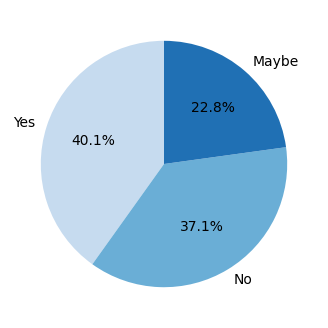

In [12]:
distr = df["current_mental_health_disorder"].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(
    distr,
    labels=distr.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("Blues", len(distr)),
    startangle=90,
)

plt.show()

Rozkład wartości w kolumnie wiek, bez filtrowania nieprawidłowych wartości

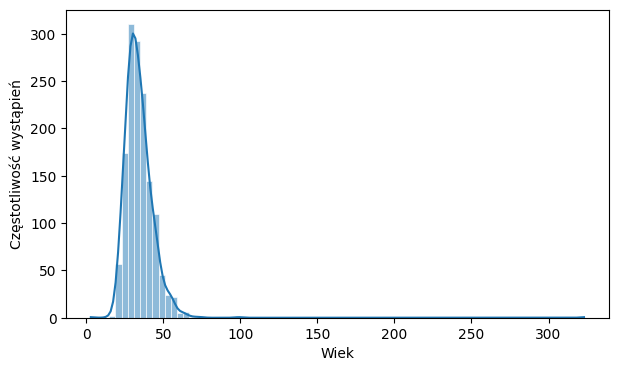

In [13]:
plt.figure(figsize=(7, 4))

sns.histplot(df["age"], kde=True, bins=80, edgecolor="white")

plt.xlabel("Wiek")
plt.ylabel("Częstotliwość wystąpień")
plt.show()


Unikatowe wartości w kolumnie gender

In [15]:
genders = df["gender"].str.lower().str.strip().unique()
print(genders)
len(genders)

['male' 'female' 'm' 'i identify as female.' 'bigender' 'non-binary'
 'female assigned at birth' 'f' 'woman' 'man' 'fm' 'cis female'
 'transitioned, m2f' 'genderfluid (born female)' 'other/transfeminine'
 'female or multi-gender femme' 'female/woman' 'cis male' 'male.'
 'androgynous' 'male 9:1 female, roughly' nan 'male (cis)' 'other'
 'nb masculine' 'cisgender female' 'sex is male' 'none of your business'
 'genderqueer' 'human' 'genderfluid' 'enby' 'malr' 'genderqueer woman'
 'mtf' 'queer' 'agender' 'dude' 'fluid'
 "i'm a man why didn't you make this a drop down question. you should of asked sex? and i would of answered yes please. seriously how much text can this take?"
 'mail' 'm|' 'male/genderqueer' 'fem' 'nonbinary'
 'female (props for making this a freeform field, though)' 'unicorn'
 'male (trans, ftm)' 'cis-woman' 'cisdude' 'genderflux demi-girl'
 'female-bodied; no feelings about gender' 'cis man' 'afab'
 'transgender woman']


55

## Transformacje

Contingency questions (pytania zależne od odpowiedzi na pytanie-cel modelowania)

In [18]:
contingency_question_columns = [
    "diagnosed_conditions",  # Only applicable to those diagnosed
    "believed_conditions",  # Only applicable to those who answered "maybe"
    "diagnosed_by_professional",  # Only applicable to those diagnosed
    "conditions_diagnosed",  # Only applicable to those diagnosed
    "sought_treatment",  # Only applicable to those diagnosed
    "interference_when_treated",  # Only applicable to those diagnosed
    "interference_when_not_treated",  # Only applicable to those diagnosed
    "work_state",  # Only applicable to US residents
    "state_of_residence",  # Only applicable to US residents
    "past_mental_health_disorder",
    "willing_to_share_with_family_friends",  # Jest odpowiedź "Not applicable to me (I do not have a mental illness)"!
]

Pytania otwarte których liczba unikatowych wartości przekracza 10% wszystkich rekordów w zbiorze danych

In [19]:
open_ended_columns = [
    "reason_discussing_physical_health",
    "reason_discussing_mental_health",
    "work_position",
]

Kolumny które mają ponad 30% missing values

In [20]:
threshold = 0.3
cols_with_over_30_missing = [
    col for col in df.columns if df[col].isna().mean() > threshold
]
cols_with_over_30_missing

reverse_column_rename_dict = {v: k for k, v in column_rename_dict.items()}

original_names = [reverse_column_rename_dict[col] for col in cols_with_over_30_missing]

original_names

['role_in_tech',
 'medical_coverage_mental_health',
 'knowledge_of_resources',
 'reveal_mental_health_to_clients',
 'negative_impact_revealing_to_clients',
 'reveal_mental_health_to_coworkers',
 'negative_impact_revealing_to_coworkers',
 'productivity_affected_by_mental_health',
 'percentage_work_time_affected',
 'observations_made_less_likely_to_reveal',
 'diagnosed_conditions',
 'believed_conditions',
 'conditions_diagnosed',
 'state_of_residence',
 'work_state']

## Preprocessing

Mapping wartości w kolumnie gender

In [22]:
gender_mapping = {
    "male": [
        "male",
        "m",
        "man",
        "cis male",
        "male.",
        "male (cis)",
        "sex is male",
        "malr",
        "dude",
        "i'm a man why didn't you make this a drop down question. you should of asked sex? and i would of answered yes please. seriously how much text can this take?",
        "mail",
        "m|",
        "cisdude",
        "cis man",
    ],
    "female": [
        "female",
        "i identify as female.",
        "female assigned at birth",
        "f",
        "woman",
        "fm",
        "cis female",
        "female or multi-gender femme",
        "female/woman",
        "fem",
        "female (props for making this a freeform field, though)",
        "cis-woman",
    ],
    "other": [
        "bigender",
        "non-binary",
        "transitioned, m2f",
        "genderfluid (born female)",
        "other/transfeminine",
        "androgynous",
        "male 9:1 female, roughly",
        "other",
        "nb masculine",
        "cisgender female",
        "none of your business",
        "genderqueer",
        "human",
        "genderfluid",
        "enby",
        "genderqueer woman",
        "mtf",
        "queer",
        "agender",
        "fluid",
        "male/genderqueer",
        "nonbinary",
        "unicorn",
        "male (trans, ftm)",
        "genderflux demi-girl",
        "female-bodied; no feelings about gender",
        "afab",
        "transgender woman",
        "",
    ],
}

GenderTransformer

In [23]:
class GenderTransformer(BaseEstimator, TransformerMixin):
    """
    Transforms the values of any column(s) passed in by ColumnTransformer
    using the specified mapping dictionary.
    """

    def __init__(self, mapping_dict: dict):
        self.mapping_dict = mapping_dict

    def fit(self, X: pd.DataFrame, y=None) -> "GenderTransformer":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()
        for col in X_copy.columns:
            X_copy[col] = X_copy[col].str.lower().str.strip().fillna("")
            for category, variants in self.mapping_dict.items():
                X_copy.loc[X_copy[col].isin([v.lower() for v in variants]), col] = (
                    category
                )
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return input_features


AgeTransformer

In [24]:
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_age: int = 18, max_age: int = 122):
        self.min_age = min_age
        self.max_age = max_age

    def fit(self, X: pd.DataFrame, y=None) -> "AgeTransformer":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()
        median_age = X_copy["age"].median()
        X_copy.loc[
            (X_copy["age"] < self.min_age) | (X_copy["age"] > self.max_age), "age"
        ] = median_age
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return input_features

Preprocesor danych

In [164]:
from sklearn.calibration import LabelEncoder


drop_columns = list(
    set(contingency_question_columns + open_ended_columns + cols_with_over_30_missing)
)

num_columns = (
    df.drop(columns=drop_columns + ["age"]).select_dtypes(include="number").columns
)

num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
    ]
)

cat_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first")),
    ]
)

gender_pipeline = Pipeline(
    [
        ("gender_transformer", GenderTransformer(mapping_dict=gender_mapping)),
        ("encoder", OneHotEncoder(drop="first")),
    ]
)

age_pipeline = Pipeline(
    [
        ("age_transformer", AgeTransformer(min_age=18, max_age=122)),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
    ]
)

preprocessor_x = ColumnTransformer(
    transformers=[
        ("drop", "drop", drop_columns),
        ("age", age_pipeline, ["age"]),
        ("gender", gender_pipeline, ["gender"]),
        ("num", num_pipeline, num_columns),
    ],
    remainder=cat_pipeline,
    verbose_feature_names_out=False,
)

In [165]:
preprocessor_y = LabelEncoder()

In [166]:
X = df.drop(columns=["current_mental_health_disorder"])
y = df["current_mental_health_disorder"]

X_transformed = pd.DataFrame(
    preprocessor_x.fit_transform(X).toarray(),
    columns=preprocessor_x.get_feature_names_out(),
)
y_transformed = pd.DataFrame(
    preprocessor_y.fit_transform(y), columns=["current_mental_health_disorder"]
)

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y_transformed, test_size=0.2, random_state=42, stratify=y_transformed
)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1146, 190), (287, 190), (1146,), (287,))

In [167]:
X_train.columns

Index(['age', 'gender_male', 'gender_other', 'self_employed',
       'employer_tech_company', 'previous_employers', 'company_size_100-500',
       'company_size_26-100', 'company_size_500-1000', 'company_size_6-25',
       ...
       'work_country_Sweden', 'work_country_Switzerland',
       'work_country_Turkey', 'work_country_United Arab Emirates',
       'work_country_United Kingdom', 'work_country_United States of America',
       'work_country_Venezuela', 'work_country_Vietnam', 'work_remotely_Never',
       'work_remotely_Sometimes'],
      dtype='object', length=190)

In [168]:
preprocessor_y_name_mapping = {
    i: name for i, name in enumerate(preprocessor_y.classes_)
}
preprocessor_y_name_mapping

{0: 'Maybe', 1: 'No', 2: 'Yes'}

Funckja do zestawienia wyników modeli, wykorzystująca accuracy score, confusion matrix (macierz pomyłek) i krzywą ROC-AUC

In [192]:
from sklearn.metrics import (
    auc,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
)


def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the fitted model performance on the training and test sets.
    Computes the accuracy, precision, recall, and F1 score and shows the
    confusion matrix and ROC curve for class 2 (Yes) vs the others.
    """

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Model :: {model.__class__.__name__} \n")

    print("Training set")
    print("-------------")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(
        f"Precision: {precision_score(y_train, y_train_pred, average='weighted'):.3f}"
    )
    print(f"Recall: {recall_score(y_train, y_train_pred, average='weighted'):.3f}")
    print(f"F1 score: {f1_score(y_train, y_train_pred, average='weighted'):.3f}")

    print("\n")

    print("Test set:")
    print("----------")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted'):.3f}")
    print(f"Recall: {recall_score(y_test, y_test_pred, average='weighted'):.3f}")
    print(f"F1 score: {f1_score(y_test, y_test_pred, average='weighted'):.3f}")

    print("\nConfusion matrix:")
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    conf_matrix_labels = [
        preprocessor_y_name_mapping[label]
        for label in range(len(preprocessor_y_name_mapping))
    ]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=conf_matrix_labels,
        yticklabels=conf_matrix_labels,
    )
    plt.title("Macierz pomyłek")
    plt.xlabel("Klasa przewidziana")
    plt.ylabel("Klasa rzeczywista")

    plt.subplot(1, 2, 2)
    y_test_bin = (y_test == 2).astype(int)
    y_test_pred_prob = model.predict_proba(X_test)[:, 2]
    fpr, tpr, _ = roc_curve(y_test_bin, y_test_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"Krzywa ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Krzywa ROC - 'Yes' vs pozostałe ('No', 'Maybe')")
    plt.legend(loc="lower right")

    plt.suptitle(
        f"Model {model.__class__.__name__}\n Train Accuracy: {train_accuracy:.4f}\n Test accuracy: {test_accuracy:.4f}",
        fontsize=14,
        ha="center",
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Modelowanie

Regresja logistyczna

In [170]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=100)

# Train the model
log_reg.fit(X_train, y_train)

LogisticRegression()

Model :: LogisticRegression 

Training set
-------------
Accuracy: 0.6667
Precision: 0.655
Recall: 0.667
F1 score: 0.653


Test set:
----------
Accuracy: 0.5854
Precision: 0.563
Recall: 0.585
F1 score: 0.569

Confusion matrix:


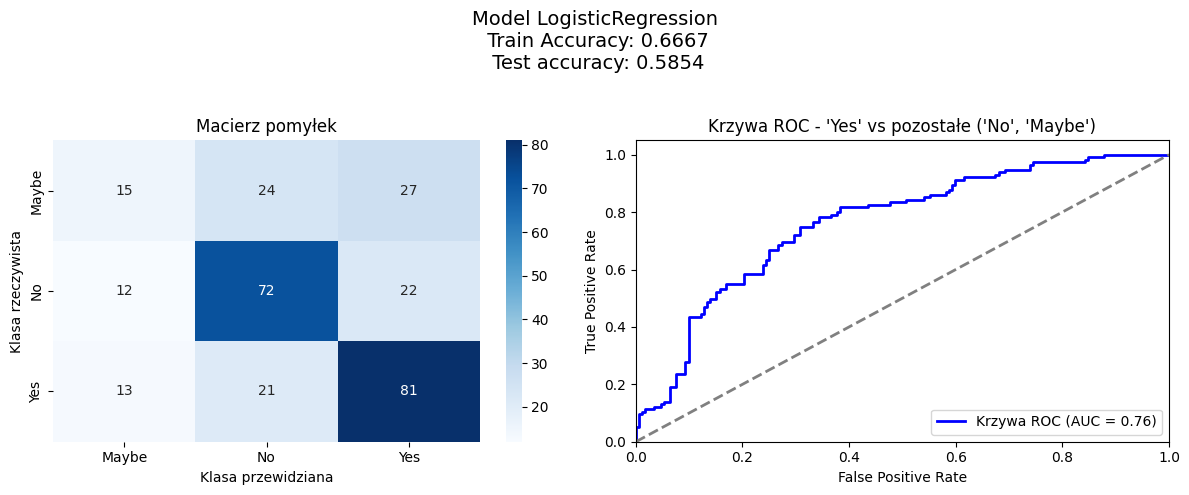

In [ ]:
evaluate_model(log_reg, X_train, y_train, X_test, y_test)

Lasy losowe

In [172]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForest model
rf_clf = RandomForestClassifier(random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Model :: RandomForestClassifier 

Training set
-------------
Accuracy: 1.0000
Precision: 1.000
Recall: 1.000
F1 score: 1.000


Test set:
----------
Accuracy: 0.5923
Precision: 0.574
Recall: 0.592
F1 score: 0.540

Confusion matrix:


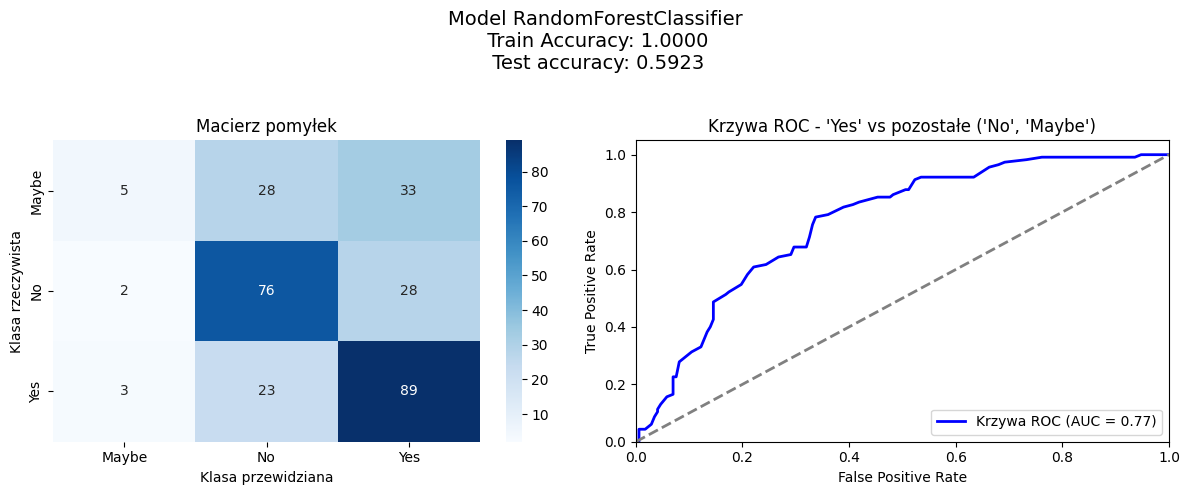

In [196]:
evaluate_model(rf_clf, X_train, y_train, X_test, y_test)

XGBoost

In [174]:
from xgboost import XGBClassifier

# Initialize the XGBoost model
xgb_clf = XGBClassifier()

# Train the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Model :: XGBClassifier 

Training set
-------------
Accuracy: 1.0000
Precision: 1.000
Recall: 1.000
F1 score: 1.000


Test set:
----------
Accuracy: 0.5540
Precision: 0.539
Recall: 0.554
F1 score: 0.543

Confusion matrix:


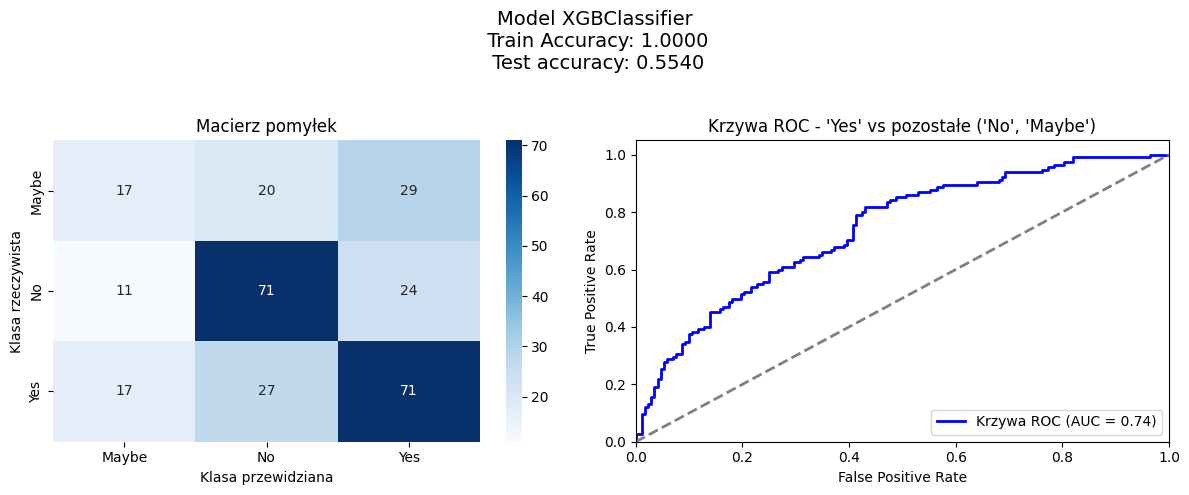

In [197]:
evaluate_model(xgb_clf, X_train, y_train, X_test, y_test)

XGBRF

In [176]:
from xgboost import XGBRFClassifier

# Initialize the XGBoost model
xgbrf_clf = XGBRFClassifier()

# Train the model
xgbrf_clf.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob',
                random_state=None, reg_alpha=None, ...)

Model :: XGBRFClassifier 

Training set
-------------
Accuracy: 0.7435
Precision: 0.755
Recall: 0.743
F1 score: 0.731


Test set:
----------
Accuracy: 0.6167
Precision: 0.601
Recall: 0.617
F1 score: 0.580

Confusion matrix:


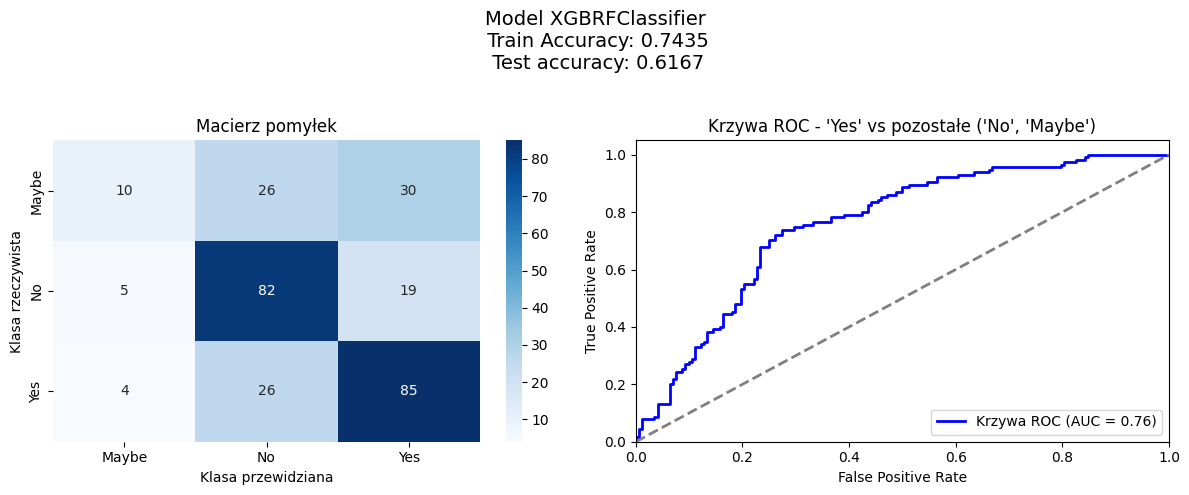

In [198]:
evaluate_model(xgbrf_clf, X_train, y_train, X_test, y_test)

## Regularyzacja

Z wykorzystaniem RandomizedSearchCV

Regresja logistyczna

In [ ]:
from scipy.stats import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param_dist_logreg = {
    "C": loguniform(1e-4, 1e2),
    "penalty": ["l2"],  # L2 regularization
    "solver": ["lbfgs", "saga"],  # Do regularyzaji L2
    "max_iter": [100, 200, 300, 500],
    "class_weight": [None, "balanced"],  # class imbalance
}

# Logistic Regression RandomizedSearchCV
random_search_logreg = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_dist_logreg,
    n_iter=50,
    scoring="accuracy",
    cv=5,
    random_state=42,
    n_jobs=-1,
)

random_search_logreg.fit(X_train, y_train)

print("Best params for LogisticRegression ::", random_search_logreg.best_params_)

log_reg_best = random_search_logreg.best_estimator_

/Users/kacperkedzierski/Documents/Code/Repositories/wad-health-in-tech/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kacperkedzierski/Documents/Code/Repositories/wad-health-in-tech/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kacperkedzierski/Documents/Code/Repositories/wad-health-in-tech/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kacperkedzierski/Documents/Code/Repositories/wad-health-in-tech/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kacperkedzierski/Documents/Co

Best params for LogisticRegression :: {'C': np.float64(0.00444970026870757), 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


/Users/kacperkedzierski/Documents/Code/Repositories/wad-health-in-tech/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model :: LogisticRegression 

Training set
-------------
Accuracy: 0.5881
Precision: 0.454
Recall: 0.588
F1 score: 0.512


Test set:
----------
Accuracy: 0.5575
Precision: 0.431
Recall: 0.557
F1 score: 0.485

Confusion matrix:


/Users/kacperkedzierski/Documents/Code/Repositories/wad-health-in-tech/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kacperkedzierski/Documents/Code/Repositories/wad-health-in-tech/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


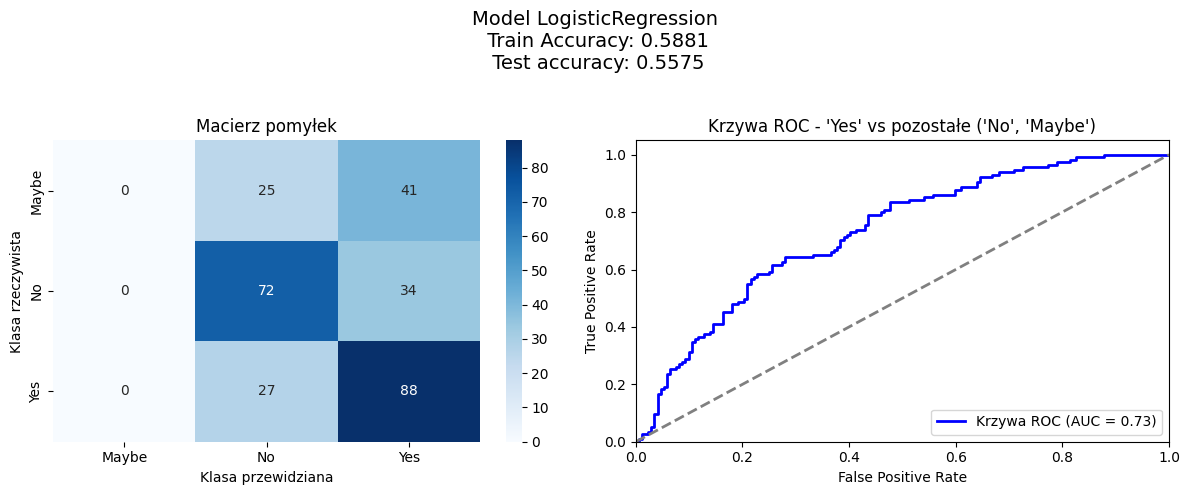

In [199]:
evaluate_model(log_reg_best, X_train, y_train, X_test, y_test)

Lasy losowe

In [190]:
param_dist_rf = {
    "n_estimators": randint(100, 501),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2"],
}

# RandomForest RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=50,
    scoring="accuracy",
    cv=5,
    random_state=42,
    n_jobs=-1,
)

random_search_rf.fit(X_train, y_train)

print("Best params for RandomForest ::", random_search_rf.best_params_)

rf_clf_best = random_search_rf.best_estimator_

Best params for RandomForest :: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 445}


Model :: RandomForestClassifier 

Training set
-------------
Accuracy: 0.6972
Precision: 0.760
Recall: 0.697
F1 score: 0.638


Test set:
----------
Accuracy: 0.5610
Precision: 0.432
Recall: 0.561
F1 score: 0.488

Confusion matrix:


/Users/kacperkedzierski/Documents/Code/Repositories/wad-health-in-tech/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


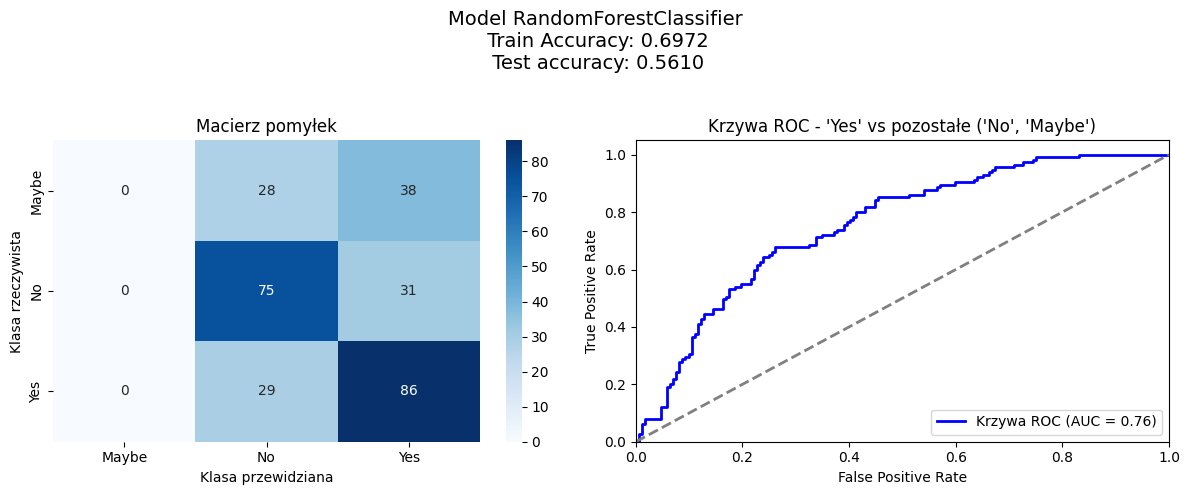

In [200]:
evaluate_model(rf_clf_best, X_train, y_train, X_test, y_test)

XGBoost

In [182]:
param_dist_xgb = {
    "learning_rate": loguniform(1e-3, 1e-1),
    "n_estimators": randint(100, 501),
    "max_depth": randint(3, 11),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
}

# XGBoost RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring="accuracy",
    cv=5,
    random_state=42,
)

random_search_xgb.fit(X_train, y_train)

print("Best params for XGBoost ::", random_search_xgb.best_params_)

xgb_clf_best = random_search_xgb.best_estimator_

Best params for XGBoost :: {'colsample_bytree': np.float64(0.918855052953664), 'learning_rate': np.float64(0.022458473505101228), 'max_depth': 3, 'n_estimators': 250, 'subsample': np.float64(0.770723986913783)}


Model :: XGBClassifier 

Training set
-------------
Accuracy: 0.6702
Precision: 0.680
Recall: 0.670
F1 score: 0.642


Test set:
----------
Accuracy: 0.6098
Precision: 0.601
Recall: 0.610
F1 score: 0.570

Confusion matrix:


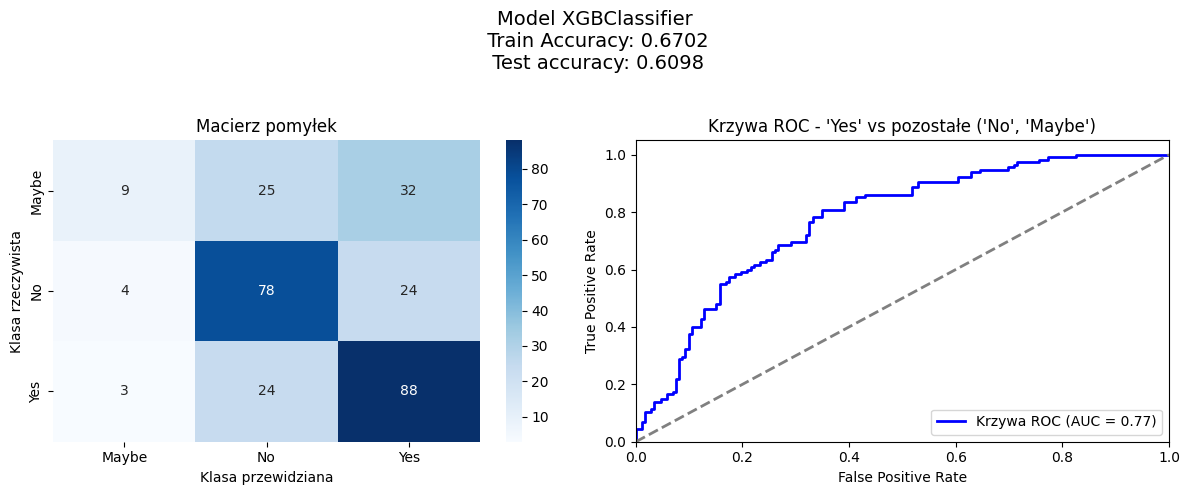

In [201]:
evaluate_model(xgb_clf_best, X_train, y_train, X_test, y_test)

XGBRF

In [ ]:
param_dist_xgbrf = {
    "learning_rate": loguniform(1e-4, 1e-1),
    "n_estimators": randint(100, 1001),
    "max_depth": randint(3, 12),
    "min_child_weight": randint(1, 10),
    "gamma": loguniform(1e-3, 1),
    "subsample": uniform(0.6, 0.4),  # Range [0.6, 1.0]
    "colsample_bytree": uniform(0.6, 0.4),  # Range [0.6, 1.0]
    "reg_alpha": loguniform(1e-3, 10),
    "reg_lambda": loguniform(1e-3, 10),
    "num_parallel_tree": randint(2, 11),
    "objective": ["multi:softprob"],  # For 3-class classification
}

# XGBoostRF RandomizedSearchCV
random_search_xgbrf = RandomizedSearchCV(
    estimator=XGBRFClassifier(),
    param_distributions=param_dist_xgbrf,
    n_iter=100,
    scoring="accuracy",
    cv=5,
    random_state=42,
)

random_search_xgbrf.fit(X_train, y_train)

print("Best params for XGBoostRF ::", random_search_xgbrf.best_params_)

xgbrf_clf_best = random_search_xgbrf.best_estimator_

Best params for XGBoostRF :: {'colsample_bytree': np.float64(0.682231923350255), 'gamma': np.float64(0.2308711499552642), 'learning_rate': np.float64(0.006473879256791667), 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 636, 'num_parallel_tree': 7, 'objective': 'multi:softprob', 'reg_alpha': np.float64(0.024287565087611766), 'reg_lambda': np.float64(0.02442377596403895), 'subsample': np.float64(0.8950004992438994)}


Model :: XGBRFClassifier 

Training set
-------------
Accuracy: 0.6449
Precision: 0.686
Recall: 0.645
F1 score: 0.599


Test set:
----------
Accuracy: 0.5993
Precision: 0.593
Recall: 0.599
F1 score: 0.542

Confusion matrix:


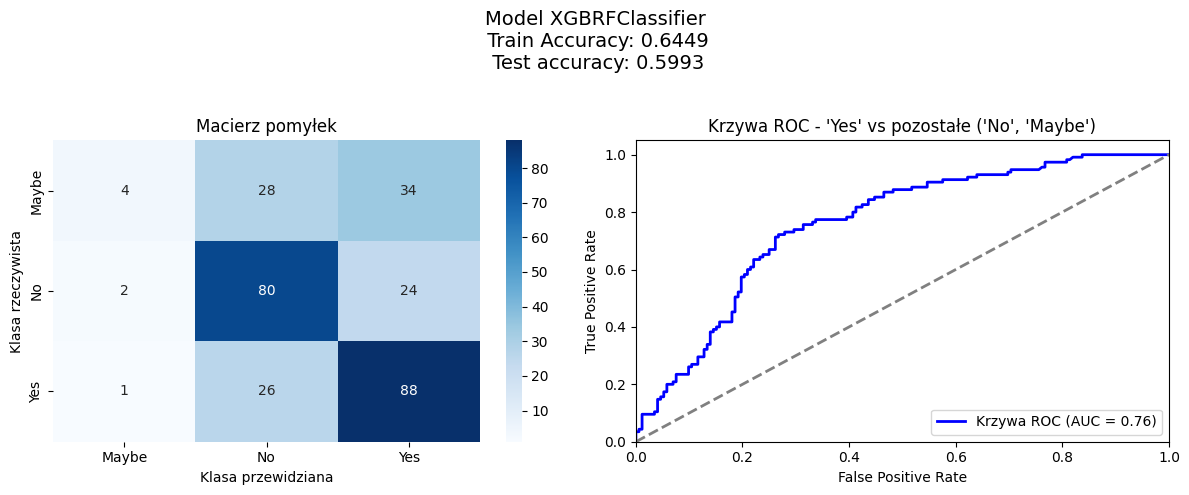

In [202]:
evaluate_model(xgbrf_clf_best, X_train, y_train, X_test, y_test)

In [213]:
feature_importances = xgbrf_clf_best.get_booster().get_score(importance_type="gain")
feature_importances

{'age': 1.8961032629013062,
 'gender_male': 4.376011848449707,
 'gender_other': 2.4184634685516357,
 'self_employed': 3.440157175064087,
 'employer_tech_company': 1.8713902235031128,
 'previous_employers': 1.7783030271530151,
 'company_size_100-500': 1.2818496227264404,
 'company_size_26-100': 2.5538618564605713,
 'company_size_500-1000': 2.212249517440796,
 'company_size_6-25': 2.1851654052734375,
 'company_size_More than 1000': 1.760892629623413,
 'mental_health_benefits_No': 2.523345947265625,
 'mental_health_benefits_Not eligible for coverage / N/A': 2.121497631072998,
 'mental_health_benefits_Yes': 3.4348251819610596,
 'mental_health_coverage_options_No': 2.437455892562866,
 'mental_health_coverage_options_Yes': 3.2862837314605713,
 'employer_discussed_mental_health_No': 2.8611536026000977,
 'employer_discussed_mental_health_Yes': 2.0922954082489014,
 'mental_health_resources_No': 1.6272374391555786,
 'mental_health_resources_Yes': 1.4872429370880127,
 'anonymity_protection_No': 1

/var/folders/5j/c9443ny96w1dn8fvj92_g8700000gn/T/ipykernel_51566/3675930674.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top_5_features, palette="Blues_d")


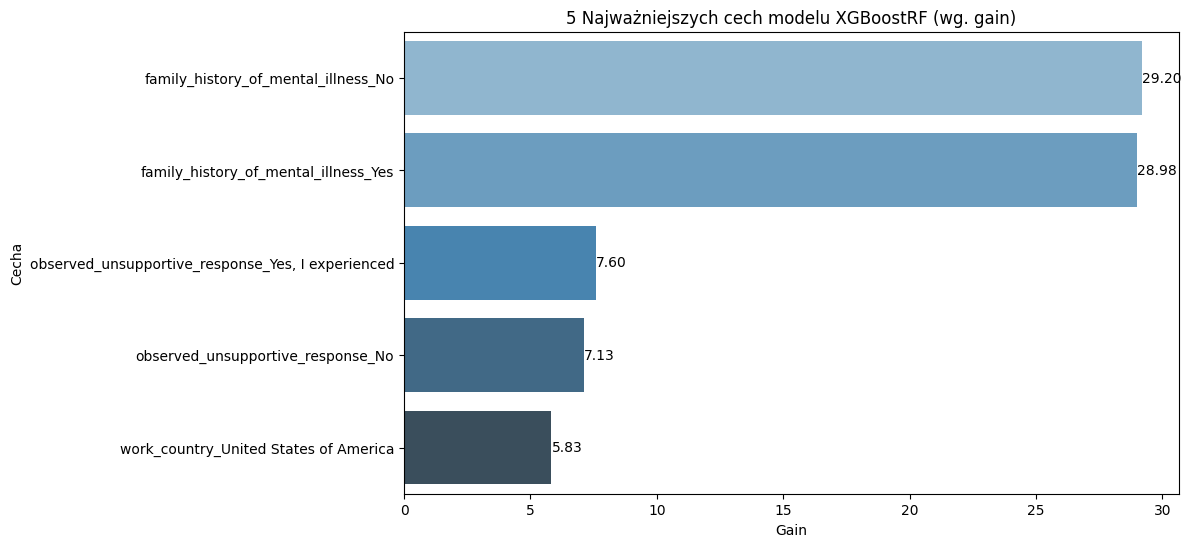

In [212]:
feature_importances_df = pd.DataFrame(
    feature_importances.items(), columns=["Feature", "Importance"]
)

top_5_features = feature_importances_df.sort_values(
    by="Importance", ascending=False
).head(5)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top_5_features, palette="Blues_d")

# Add score at the end of each bar
for index, value in enumerate(top_5_features["Importance"]):
    plt.text(value, index, f"{value:.2f}", va="center")

plt.title("5 Najważniejszych cech modelu XGBoostRF (wg. gain)")
plt.xlabel("Gain")
plt.ylabel("Cecha")
plt.show()

/var/folders/5j/c9443ny96w1dn8fvj92_g8700000gn/T/ipykernel_51566/223484422.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Classifier", y="Accuracy", data=accuracy_df, palette="Blues_d")


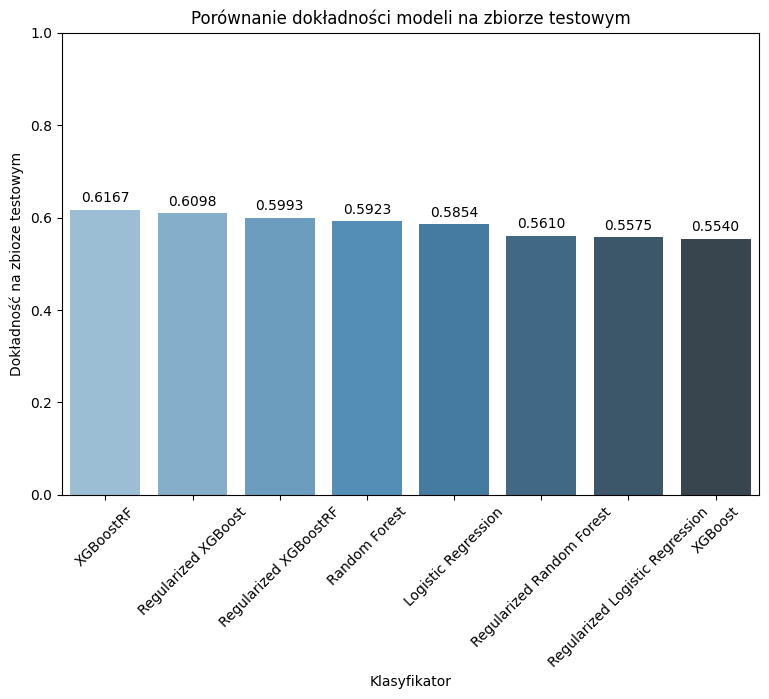

In [ ]:
classifiers = [
    "Logistic Regression",
    "Random Forest",
    "XGBoost",
    "XGBoostRF",
    "Regularized Logistic Regression",
    "Regularized Random Forest",
    "Regularized XGBoost",
    "Regularized XGBoostRF",
]

test_accuracies = [
    accuracy_score(y_test, log_reg.predict(X_test)),
    accuracy_score(y_test, rf_clf.predict(X_test)),
    accuracy_score(y_test, xgb_clf.predict(X_test)),
    accuracy_score(y_test, xgbrf_clf.predict(X_test)),
    accuracy_score(y_test, log_reg_best.predict(X_test)),
    accuracy_score(y_test, rf_clf_best.predict(X_test)),
    accuracy_score(y_test, xgb_clf_best.predict(X_test)),
    accuracy_score(y_test, xgbrf_clf_best.predict(X_test)),
]

accuracy_df = pd.DataFrame({"Classifier": classifiers, "Accuracy": test_accuracies})
accuracy_df = accuracy_df.sort_values(by="Accuracy", ascending=False)

# Plot
plt.figure(figsize=(9, 6))
sns.barplot(x="Classifier", y="Accuracy", data=accuracy_df, palette="Blues_d")
plt.xlabel("Klasyfikator")
plt.ylabel("Dokładność na zbioze testowym")
plt.title("Porównanie dokładności modeli na zbiorze testowym")
plt.ylim(0, 1)

# Add accuracy values
for i, acc in enumerate(accuracy_df["Accuracy"]):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha="center", va="bottom")

plt.xticks(rotation=45)
plt.show()